In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
#
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
#
# pip install

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from tqdm import tqdm
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

### Область работы 2 (поиск лучшей модели)

Я вас приветствую на разведовательном анализе датасета вина. Для начала прочитаем наш файл wine_train, и просмотрим описательную статистику по столбцам.

In [4]:
path_train = "wine_train.csv"
df = pd.read_csv(path_train)

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000
mean,6.846665,0.278138,0.334568,6.428233,0.045736,35.081269,138.022189,0.994023,3.187414,0.488647,10.516330,5.878029
std,0.831783,0.101203,0.119855,5.134907,0.021699,16.582853,42.179044,0.003027,0.150749,0.112795,1.230426,0.885823
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991700,3.080000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.250000,0.043000,33.000000,134.000000,0.993730,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,45.000000,166.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,11.800000,1.100000,1.230000,65.800000,0.346000,146.500000,366.500000,1.038980,3.800000,1.080000,14.200000,9.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3673 non-null   float64
 1   volatile acidity      3673 non-null   float64
 2   citric acid           3673 non-null   float64
 3   residual sugar        3673 non-null   float64
 4   chlorides             3673 non-null   float64
 5   free sulfur dioxide   3673 non-null   float64
 6   total sulfur dioxide  3673 non-null   float64
 7   density               3673 non-null   float64
 8   pH                    3673 non-null   float64
 9   sulphates             3673 non-null   float64
 10  alcohol               3673 non-null   float64
 11  quality               3673 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 344.5 KB


Заменим наши таргет-метки на классы 0 и 1 согласно условию домашнего задания (1 - отмечаются те вина, у кого качества 7 и выше, 0 - иначе)

In [7]:
df['quality']= np.where(df.quality>=7, 1, 0)

In [8]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.2,0.28,0.22,7.3,0.041,26.0,157.0,0.99570,3.44,0.64,9.8,1
1,5.9,0.54,0.00,0.8,0.032,12.0,82.0,0.99286,3.25,0.36,8.8,0
2,6.2,0.24,0.27,16.8,0.040,48.0,129.0,0.99691,3.23,0.38,10.5,0
3,6.7,0.42,0.46,9.7,0.054,67.0,234.0,0.99848,3.23,0.50,9.0,0
4,7.0,0.20,0.34,2.1,0.049,12.0,136.0,0.99220,3.25,0.46,11.6,1


Проверим данные на дубликаты и удалим их.

In [8]:
df[df.duplicated()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
296,7.6,0.32,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,0
302,6.0,0.28,0.24,17.80,0.047,42.0,111.0,0.99896,3.10,0.45,8.9,0
343,6.4,0.33,0.44,8.90,0.055,52.0,164.0,0.99488,3.10,0.48,9.6,0
385,5.7,0.26,0.24,17.80,0.059,23.0,124.0,0.99773,3.30,0.50,10.1,0
387,6.4,0.18,0.74,11.90,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3660,7.0,0.24,0.30,4.20,0.040,41.0,213.0,0.99270,3.28,0.49,11.8,0
3664,7.0,0.16,0.25,14.30,0.044,27.0,149.0,0.99800,2.91,0.46,9.2,0
3665,6.8,0.21,0.55,14.60,0.053,34.0,159.0,0.99805,2.93,0.44,9.2,0
3667,7.2,0.23,0.38,14.30,0.058,55.0,194.0,0.99790,3.09,0.44,9.0,0


In [9]:
df[df.duplicated()]['quality'].value_counts() # В принципе у нас дубли не перевешивают в пользу какого-то класса
#     (условно, если бы у нас были дубликаты только для 1 класса, то их удаление могло повлиять на качество обучения, 
#     в нашем случае можно удалять дубликаты чтобы не допустить утечки данных)

0    412
1    148
Name: quality, dtype: int64

In [10]:
df = df.drop_duplicates()

Посмотрим баланс классов. И как мы видим, 80 % вин соответствуют классу 0, и 20% вин соотвествуют классу 1. Это значит, что когда мы будем применять в сетке кросс-валидацию (перекрестную проверку) мы должны выбрать StratifiedKFold, чтобы наши обучающие и поверочные сплиты разделялись пропорционально объемам классов.

In [11]:
df.quality.mean()

0.20783809829746225

In [12]:
df.shape

(3113, 12)

Теперь самое интересное, выбросы. Как вы видите, у нас имеется довольно большие выбросы в столбце free sulfur dioxide и total sulfur dioxide. На самом деле, мы могли бы их исключить, или заменять их на медианное значение. Но... возможно они не являются выбросами?

На самом деле, если сделать разбивку по quality исходному, по столбцам total sulfur dioxide, можно заметить, что среднее значение при quality = 3 будет 183.46, оно значительно больше, чем у вин с качеством лучше. Получается, это даже не выбросы, а норма для плохого качества вина


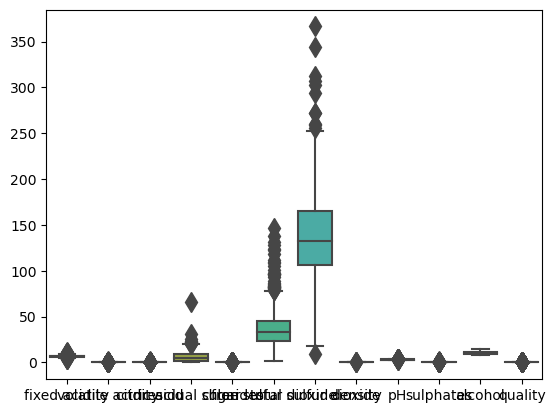

In [13]:
sns.boxplot(data = df, width=0.8, fliersize=10);

Построим корреляционную матрицу

In [14]:
corr = df.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.011352,0.285617,0.098695,0.022667,-0.057916,0.079351,0.263414,-0.439709,-0.022559,-0.097665,-0.092495
volatile acidity,-0.011352,1.000000,-0.165072,0.101484,0.097191,-0.110411,0.105878,0.067605,-0.045774,-0.022369,0.042664,-0.070411
citric acid,0.285617,-0.165072,1.000000,0.110972,0.120950,0.087536,0.119112,0.153376,-0.180810,0.048108,-0.063246,-0.010739
residual sugar,0.098695,0.101484,0.110972,1.000000,0.081543,0.318909,0.416219,0.830655,-0.173705,-0.013770,-0.406971,-0.148018
chlorides,0.022667,0.097191,0.120950,0.081543,1.000000,0.080739,0.188912,0.248452,-0.083281,0.031893,-0.343033,-0.187302
free sulfur dioxide,-0.057916,-0.110411,0.087536,0.318909,0.080739,1.000000,0.618822,0.303713,-0.006802,0.060036,-0.257783,-0.026658
total sulfur dioxide,0.079351,0.105878,0.119112,0.416219,0.188912,0.618822,1.000000,0.538444,-0.002667,0.146208,-0.454762,-0.182810
density,0.263414,0.067605,0.153376,0.830655,0.248452,0.303713,0.538444,1.000000,-0.066678,0.092702,-0.756035,-0.311288
pH,-0.439709,-0.045774,-0.180810,-0.173705,-0.083281,-0.006802,-0.002667,-0.066678,1.000000,0.147090,0.082137,0.114005
sulphates,-0.022559,-0.022369,0.048108,-0.013770,0.031893,0.060036,0.146208,0.092702,0.147090,1.000000,-0.038835,0.033035


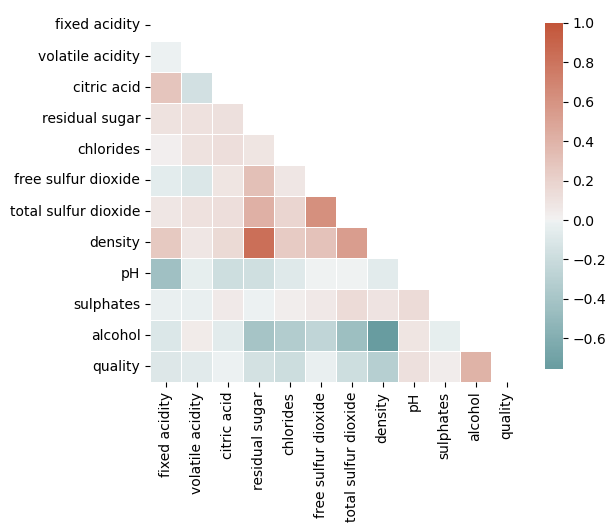

In [15]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 9))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [16]:
X = df.drop(['quality'],axis =1)
y = df['quality']

Здесь мы находим подходящую разбивку test_size, но можно было этого и не делать

In [17]:
# score_train = np.array([])
# score_test = np.array([])
# for z in np.arange(0.05,0.5,0.05):
#     for i in range(10):
#         X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = z, stratify = y, random_state = 42)
#         pipe = Pipeline([('preprocessing', StandardScaler()),
#                 ('classifier', KNeighborsClassifier())])
#         pipe.fit(X_train, y_train)
#         score_train = np.append(score_train,pipe.score(X_train , y_train))
#         score_test = np.append(score_test, pipe.score(X_test, y_test))
#     print("Среднее качество на трейне при test_size ", z, ":", np.mean(score_train))
#     print("Среднее качество на тесте при test_size ", z, ":", np.mean(score_test))
#     print("Разница между качеством train и test: ", np.mean(score_train)-np.mean(score_test))
#     print()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)

Сейчас мы будем прицеливаться к модели, которую будем использовать для нашего обучения. Для этого сделаем стандартный пайплайн, уже с выбранным препроцессингом (рабаст скалер) + модель соседей для классификации. За фитим и посмотрим score на трейне и на тесте.

### При этом мы должны определиться с метрикой. Цель работы : "научиться приобретать вино качеством от 7 и более (7, 8 и т.д.)". 

Это означает, что наша задача максимизировать действительно хорошие вина, которые предсказаны как хорошие. И минимизировать действительно плохие вина, которые предсказаны как хорошие. При этом нам будет все равно, если хорошее вино предскажется как плохое (клиент купив такое вино точно не пострадает :) ). И так это метрика - precision.  

In [19]:
pipe = Pipeline(steps=[('preprocessing', RobustScaler()),
                ('regressor',
                 KNeighborsRegressor())])
pipe.fit(X_train_new,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(precision_score(y_train, y_pred_train))
print(precision_score(y_test,y_pred_test))

#ради интереса сделаем акураси
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.7541436464088398
0.5853658536585366
0.8710368466152528
0.8189987163029525


Теперь делаем здоровую сетку с перекрестной проверкой через StratifiedKFold (позволяет разбивать обучающие и поверочные сплиты с учетом дисбаланса классов, который у нас присутствует). 

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
pipe = Pipeline([('preprocessing', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

n_neighbors  = np.arange(120,190,1)
p= [2,4,5,6,7,9]
weights = ['distance']

param_grid = [
    {'preprocessing': [RobustScaler(), Normalizer()],
    'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p,
     'classifier__weights': weights
#      'classifier__n_jobs': [-1] # задействовать все процессы
    }
] #решетка


# cross_val = StratifiedShuffleSplit(n_splits=3)
cross_val = StratifiedKFold(n_splits=5, shuffle=True)

grid = GridSearchCV(pipe,param_grid, cv=cross_val,
                    return_train_score = True, scoring = 'precision',
                   n_jobs = -1) # решетчатый поиск

# for i in tqdm([1,2,3]):
grid.fit(X_train, y_train)

In [ ]:
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending = [True]).T

Лучшая модель после выполнения очередной сетки имеет следующие параметры:

    Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=184, p=6,
                                      weights='distance'))])
                                      
Ее мы и будем использовать для обучения

In [ ]:
grid.best_estimator_ 

In [20]:
pipe_best = Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=184, p=6,
                                      weights='distance'))])

pipe_best.fit(X_train,y_train)

y_pred_train = pipe_best.predict(X_train)
y_pred_test = pipe_best.predict(X_test)

print(precision_score(y_train,y_pred_train))
print(precision_score(y_test,y_pred_test))

# для интереса посмотрим акураси
print(pipe_best.score(X_train,y_train))
print(pipe_best.score(X_test,y_test))

1.0
0.8181818181818182
1.0
0.8010269576379975


Confusion матрица для train и для test

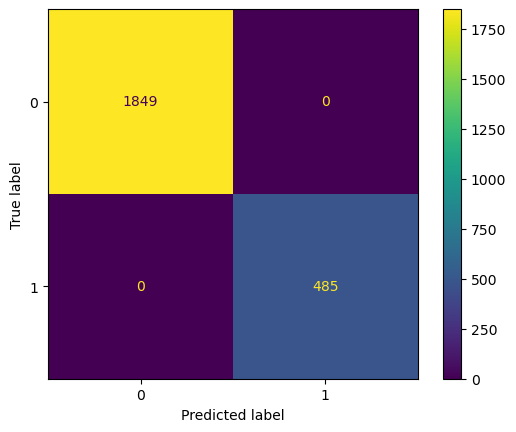

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred_train)).plot();

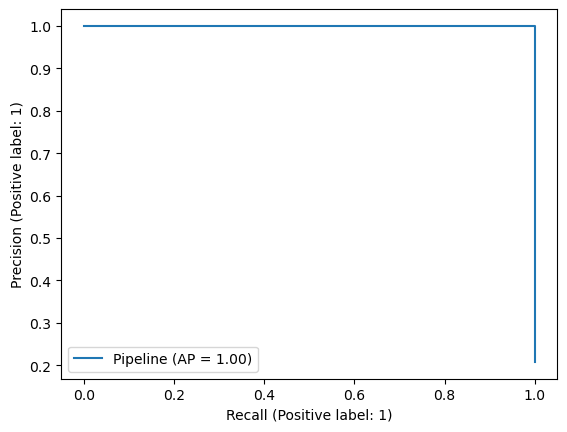

In [22]:
PrecisionRecallDisplay.from_estimator(pipe_best, X_train, y_train);

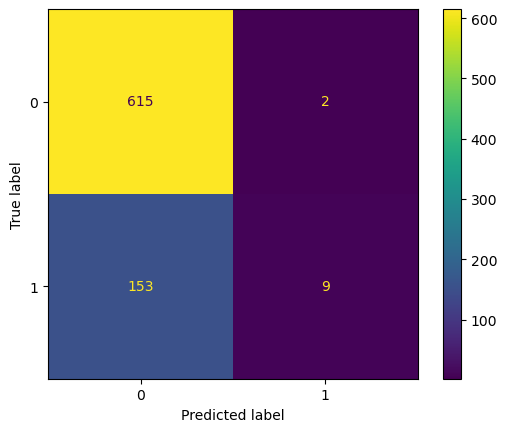

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_test)).plot();

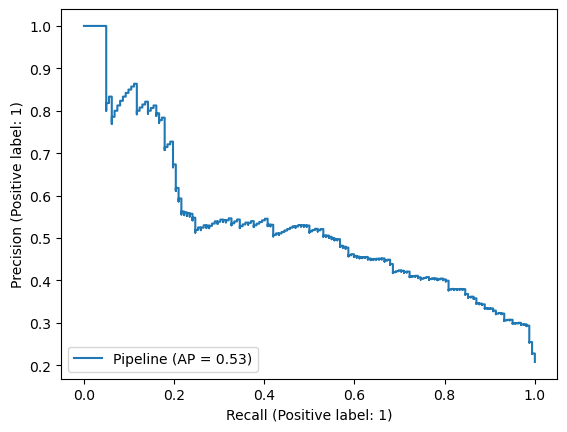

In [24]:
PrecisionRecallDisplay.from_estimator(pipe_best, X_test, y_test);

### Область работы 3 (выполнение лучшей модели)

In [25]:
# Данный блок(и) в области 3 выполняется преподавателем
#
# В области находится одна, единственная, итоговая модель машинного обучения с однозначными, 
# зафиксированными параметрами
#
# В данной области категорически запрещается искать, выбирать, улучшать, оптимизировать, 
# тюниговать и т.д. модель машинного обучения

In [26]:
# Путь к тренировочному набору
path_train = 'wine_train.csv' # содержит только имя файла, без имен папок
# Путь к тестовому набору
path_test  = 'wine_test.csv' # содержит только имя файла, без имен папок

df_train = pd.read_csv(path_train)
X_test = pd.read_csv(path_test)

X_train = df_train.drop(['quality'], axis = 1)
y_train = np.where(df_train.quality>=7, 1, 0)

In [27]:
# Блок(и) обучения и поверки модели
pipe_final = Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=184, p=6,
                                      weights='distance'))])
pipe_final.fit(X_train,y_train)
y_predict_train = pipe_final.predict(X_train)
print("При n_neighbors 184 precision на трейне: ", precision_score(y_train, y_predict_train))
# ПОВЕРКА
cv = StratifiedKFold(n_splits=5, shuffle=True)
cross_val_score(pipe_final, X_train, y_train, cv=cv, scoring = 'precision')

При n_neighbors 184 precision на трейне:  1.0


array([0.95833333, 0.92647059, 0.9       , 0.95918367, 0.953125  ])

In [28]:
# Блок предсказания с использованием тестового набора

In [29]:
# Название вектора предсказанных значений  y_predict полученого на основании тестового набора
y_predict = pipe_final.predict(X_test)

In [ ]:
# y_true =


In [ ]:
# # Можно раскомментить и просмотреть скор и матрицу

# print(precision_score(y_true, y_predict))
# ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict)).plot();